In [3]:
from pathlib import Path

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

### **1. Stereo Calibration**

In [4]:
def create_world_grid(pattern_shape, pattern_size_mm):
    world_grid = np.indices((pattern_shape[0], pattern_shape[1])).transpose().reshape(-1, 2)
    world_grid = np.hstack((world_grid, np.zeros((world_grid.shape[0], 1))))
    world_grid = np.multiply(world_grid, pattern_size_mm).astype(np.float32)
    return world_grid

In [5]:
DEVICE1 = "predator"
DEVICE2 = "thinkpad"

IMAGES_DIR1 = Path(f"./assets/stereo_calib/{DEVICE1}/")
IMAGES_DIR2 = Path(f"./assets/stereo_calib/{DEVICE2}/")

PATTERN_SHAPE = (10, 7)  # Inner corners.
PATTERN_SIZE_MM = 25  # Size of the squares in mm.

CORNER_SUB_PIX_CRITERIA = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
CHESSBOARD_CORNERS_FLAGS = cv.CALIB_CB_ADAPTIVE_THRESH | cv.CALIB_CB_NORMALIZE_IMAGE

world_grid = create_world_grid(PATTERN_SHAPE, PATTERN_SIZE_MM)

predator_matrix = np.loadtxt("./assets/predator_camera_matrix.txt")
predator_dist_coeffs = np.loadtxt("./assets/predator_dist_coeffs.txt")

thinkpad_matrix = np.loadtxt("./assets/thinkpad_camera_matrix.txt")
thinkpad_dist_coeffs = np.loadtxt("./assets/thinkpad_dist_coeffs.txt")

In [6]:
image_points_predator = list()
image_points_thinkpad = list()
world_points = list()

for img_path_predator, img_path_thinkpad in zip(IMAGES_DIR1.glob("*.jpg"), IMAGES_DIR2.glob("*.jpg")):
    assert img_path_predator.name == img_path_thinkpad.name

    image_predator = cv.imread(str(img_path_predator))
    image_thinkpad = cv.imread(str(img_path_thinkpad))

    gray_predator = cv.cvtColor(image_predator, cv.COLOR_BGR2GRAY)
    gray_thinkpad = cv.cvtColor(image_thinkpad, cv.COLOR_BGR2GRAY)

    found_predator, corners_predator = cv.findChessboardCorners(
        gray_predator, PATTERN_SHAPE, flags=CHESSBOARD_CORNERS_FLAGS
    )
    found_thinkpad, corners_thinkpad = cv.findChessboardCorners(
        gray_thinkpad, PATTERN_SHAPE, flags=CHESSBOARD_CORNERS_FLAGS
    )

    print(
        f"Found corners in {img_path_predator.name}: {found_predator}",
        f"Found corners in {img_path_thinkpad.name}: {found_thinkpad}",
    )

    if found_predator and found_thinkpad:
        world_points.append(world_grid)

        corners_predator = cv.cornerSubPix(gray_predator, corners_predator, (11, 11), (-1, -1), CORNER_SUB_PIX_CRITERIA)
        corners_thinkpad = cv.cornerSubPix(gray_thinkpad, corners_thinkpad, (11, 11), (-1, -1), CORNER_SUB_PIX_CRITERIA)

        image_points_predator.append(corners_predator)
        image_points_thinkpad.append(corners_thinkpad)

    cv.drawChessboardCorners(image_predator, PATTERN_SHAPE, corners_predator, found_predator)
    cv.drawChessboardCorners(image_thinkpad, PATTERN_SHAPE, corners_thinkpad, found_thinkpad)

    cv.imshow("Predator", image_predator)
    cv.imshow("Thinkpad", image_thinkpad)
    cv.waitKey(1000)

cv.destroyAllWindows()

rms, K1, D1, K2, D2, R, T, E, F = cv.stereoCalibrate(
    objectPoints=world_points,
    imagePoints1=image_points_predator,
    imagePoints2=image_points_thinkpad,
    cameraMatrix1=predator_matrix,
    distCoeffs1=predator_dist_coeffs,
    cameraMatrix2=thinkpad_matrix,
    distCoeffs2=thinkpad_dist_coeffs,
    imageSize=gray_predator.shape[::-1],
    flags=cv.CALIB_FIX_INTRINSIC,
    criteria=(cv.TERM_CRITERIA_MAX_ITER | cv.TERM_CRITERIA_EPS, 100, 1e-5),
)

np.savetxt("./assets/stereo_calib/R.txt", R, fmt="%f")
np.savetxt("./assets/stereo_calib/T.txt", T, fmt="%f")
np.savetxt("./assets/stereo_calib/E.txt", E, fmt="%f")
np.savetxt("./assets/stereo_calib/F.txt", F, fmt="%f")

print(f"RMS: {rms}")
print(f"K1:\n {K1}")
print(f"D1:\n {D1}")
print(f"K2:\n {K2}")
print(f"D2:\n {D2}")
print(f"R:\n {R}")
print(f"T:\n {T}")
print(f"E:\n {E}")
print(f"F:\n {F}")

Found corners in frame_0250.jpg: True Found corners in frame_0250.jpg: True
Found corners in frame_0380.jpg: True Found corners in frame_0380.jpg: True
Found corners in frame_0450.jpg: True Found corners in frame_0450.jpg: True
Found corners in frame_0500.jpg: True Found corners in frame_0500.jpg: True
Found corners in frame_0730.jpg: True Found corners in frame_0730.jpg: True
Found corners in frame_0800.jpg: True Found corners in frame_0800.jpg: True
Found corners in frame_1000.jpg: True Found corners in frame_1000.jpg: True
Found corners in frame_1150.jpg: True Found corners in frame_1150.jpg: True
Found corners in frame_1240.jpg: True Found corners in frame_1240.jpg: True
Found corners in frame_1400.jpg: True Found corners in frame_1400.jpg: True
Found corners in frame_1730.jpg: False Found corners in frame_1730.jpg: True
Found corners in frame_2100.jpg: True Found corners in frame_2100.jpg: True
Found corners in frame_2300.jpg: False Found corners in frame_2300.jpg: False
Found cor

### **2. Camera Placements**

In [7]:
# https://stackoverflow.com/questions/8130823/set-matplotlib-3d-plot-aspect-ratio
def axis_equal_3d(ax):
    extents = np.array([getattr(ax, "get_{}lim".format(dim))() for dim in "xyz"])
    sz = extents[:, 1] - extents[:, 0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize / 2
    for ctr, dim in zip(centers, "xyz"):
        getattr(ax, "set_{}lim".format(dim))(ctr - r, ctr + r)


def plot_camera_position(ax, R, t, camera_size=1, arrow_len=1, arrow_ratio=0.1):
    # Maplotlib coordinate system is different from typical camera coordinate system.
    # In camera coordinate system X is right, Y is down, and Z is forward.
    swap_yz = lambda v: v[[0, 2, 1]]
    inverse_y = np.array([[1, 0, 0], [0, -1, 0], [0, 0, 1]])

    R = R @ inverse_y

    center = swap_yz(np.dot(-np.linalg.inv(R), t).flatten())
    vx = swap_yz(np.linalg.inv(R) @ np.array([1, 0, 0]))
    vy = swap_yz(np.linalg.inv(R) @ np.array([0, -1, 0]))  # Inverted Y axis.
    vz = swap_yz(np.linalg.inv(R) @ np.array([0, 0, 1]))

    ax.quiver(*center, *vx, color="r", length=arrow_len, arrow_length_ratio=arrow_ratio)
    ax.quiver(*center, *vy, color="g", length=arrow_len, arrow_length_ratio=arrow_ratio)
    ax.quiver(*center, *vz, color="b", length=arrow_len, arrow_length_ratio=arrow_ratio)
    ax.scatter(*center, color="orange", s=camera_size)

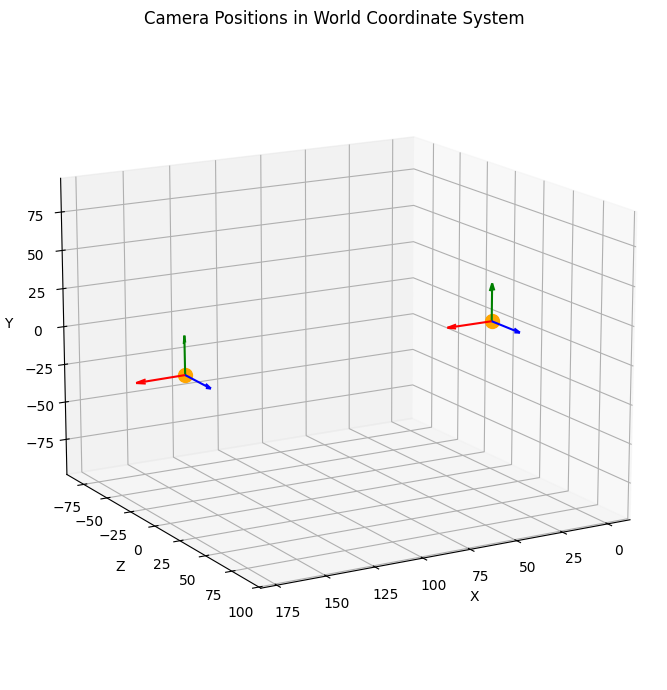

In [8]:
# %matplotlib widget

# Camera 1 is our origin.
R1 = np.eye(3)
t1 = np.zeros((3, 1))

R2 = np.array(
    [
        [9.99868793e-01, 1.61982993e-02, -1.10188622e-04],
        [-1.61977298e-02, 9.99713923e-01, -1.75984766e-02],
        [-1.74908292e-04, 1.75979523e-02, 9.99845129e-01],
    ]
)
t2 = np.array([[-170.5806684], [1.06969157], [-8.13817985]])

plt.close()
plt.figure(figsize=(7, 7), tight_layout=True)
ax = plt.axes(projection="3d")
ax.view_init(elev=15, azim=60, roll=0)  # type: ignore
ax.set_xlabel("X")
ax.set_ylabel("Z")
ax.set_zlabel("Y")  # type: ignore
ax.set_title("Camera Positions in World Coordinate System")
plot_camera_position(ax, R1, t1, 100, 25, 0.2)
plot_camera_position(ax, R2, t2, 100, 25, 0.2)
axis_equal_3d(ax)
plt.show()

### **3. Rectification**

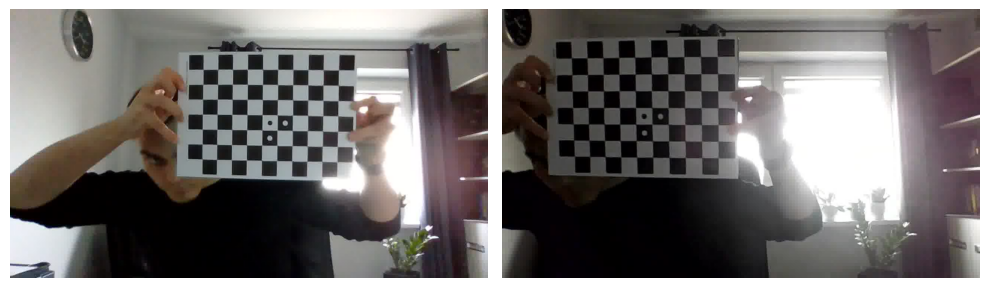

In [9]:
predator_img_path = IMAGES_DIR1.joinpath("frame_2570.jpg")
thinkpad_img_path = IMAGES_DIR2.joinpath("frame_2570.jpg")

image_predator = cv.imread(str(predator_img_path))
image_thinkpad = cv.imread(str(thinkpad_img_path))
image_size = image_predator.shape[1::-1]
channels = image_predator.shape[-1]

assert image_predator.size == image_thinkpad.size, "Images must have the same size."

plt.figure(figsize=(10, 5), tight_layout=True)
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(image_predator, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(image_thinkpad, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [10]:
def crop_image(image, roi):
    return image[roi[1] : roi[1] + roi[3], roi[0] : roi[0] + roi[2]]

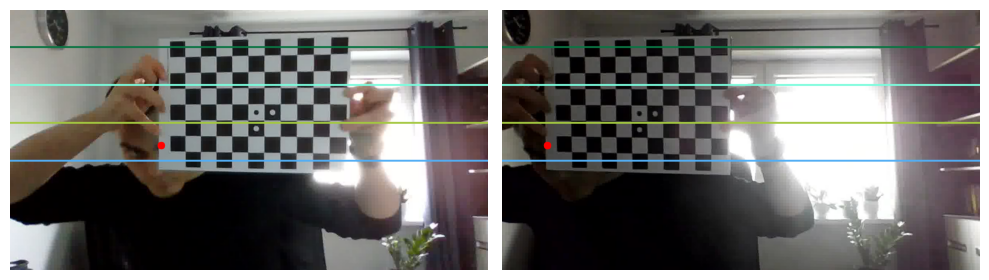

In [11]:
R = np.loadtxt("./assets/stereo_calib/R.txt")
T = np.loadtxt("./assets/stereo_calib/T.txt")

R1, R2, P1, P2, Q, roi1, roi2 = cv.stereoRectify(
    cameraMatrix1=predator_matrix,
    distCoeffs1=predator_dist_coeffs,
    cameraMatrix2=thinkpad_matrix,
    distCoeffs2=thinkpad_dist_coeffs,
    imageSize=image_size,
    R=R,
    T=T,
    flags=cv.CALIB_ZERO_DISPARITY,
)

map1x, map1y = cv.initUndistortRectifyMap(
    cameraMatrix=predator_matrix,
    distCoeffs=predator_dist_coeffs,
    R=R1,
    newCameraMatrix=P1,
    size=image_size,
    m1type=cv.CV_32FC1,
)

map2x, map2y = cv.initUndistortRectifyMap(
    cameraMatrix=thinkpad_matrix,
    distCoeffs=thinkpad_dist_coeffs,
    R=R2,
    newCameraMatrix=P2,
    size=image_size,
    m1type=cv.CV_32FC1,
)

rectified_predator = cv.remap(image_predator, map1x, map1y, cv.INTER_LINEAR)
rectified_thinkpad = cv.remap(image_thinkpad, map2x, map2y, cv.INTER_LINEAR)

rectified_predator = crop_image(rectified_predator, roi2)
rectified_thinkpad = crop_image(rectified_thinkpad, roi2)

for y in (100, 200, 300, 400):
    color = np.random.randint(0, 255, 3).tolist()
    cv.line(rectified_predator, (0, y), (1280, y), color, 4)
    cv.line(rectified_thinkpad, (0, y), (1280, y), color, 4)

cv.circle(rectified_predator, (400, 360), 10, (0, 0, 255), -1)
cv.circle(rectified_thinkpad, (120, 360), 10, (0, 0, 255), -1)

plt.figure(figsize=(10, 5), tight_layout=True)
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(rectified_predator, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(rectified_thinkpad, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

### **4. Stereo Correspondence**

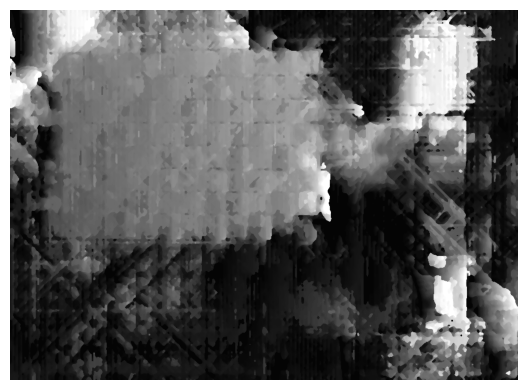

In [19]:
block_size = 3

stereo = cv.StereoSGBM.create(
    minDisparity=256,
    numDisparities=64,
    blockSize=block_size,
    P1=4 * channels * block_size**2,
    P2=256 * channels * block_size**2,
    disp12MaxDiff=256,
    speckleWindowSize=20,
    speckleRange=15,
    mode=cv.STEREO_SGBM_MODE_HH,
)
disparity_map = stereo.compute(rectified_predator, rectified_thinkpad)
cv.normalize(disparity_map, disparity_map, 0, 255, norm_type=cv.NORM_MINMAX)

ret, thresholded = cv.threshold(disparity_map.astype(np.uint8), 0, 255, cv.THRESH_OTSU)
roi = cv.boundingRect(thresholded)
disparity_map = crop_image(disparity_map, roi)
disparity_map = disparity_map.astype(np.uint8)
disparity_map = cv.medianBlur(disparity_map, 5)

plt.figure(figsize=(8, 4), tight_layout=True)
plt.imshow(disparity_map, cmap="gray")
plt.axis("off")
plt.show()